In [1]:
import pandas as pd
from pymongo import MongoClient
import seaborn as sns
import matplotlib.pyplot as plt
client = MongoClient("mongodb://localhost:27017")
db = client["climate_db"]
raw_collection = db["temperatures_raw"]

# Check if collection already exists

In [2]:
if "temperatures_raw" in db.list_collection_names():
    print("Data already exists in MongoDB. No action taken.")

else:
    df = pd.read_csv("./data/data.csv")
    records = df.to_dict(orient="records")
    raw_collection.insert_many(records)
    print("CSV data imported into MongoDB.")


Data already exists in MongoDB. No action taken.


# LOAD (MongoDB → pandas)

In [3]:


cursor = raw_collection.find(batch_size=100000) 
chunks = []

for chunk in cursor:
    chunks.append(chunk)

df = pd.DataFrame(chunks)
print("Loaded raw data into pandas. Shape:", df.shape)


Loaded raw data into pandas. Shape: (859921, 8)


# Convert dt to datetime

In [4]:
df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
df['year'] = df['dt'].dt.year
df['month'] = df['dt'].dt.month


# Convert numeric columns

In [5]:
df['AverageTemperature'] = pd.to_numeric(df['AverageTemperature'], errors='coerce')
df['AverageTemperatureUncertainty'] = pd.to_numeric(df['AverageTemperatureUncertainty'], errors='coerce')



# Drop missing temperatures

In [6]:
df = df.dropna(subset=['AverageTemperature'])

# Latitude/Longitude fix

In [7]:
def convert_lat_lon(val):
       if isinstance(val, str):
              if val[-1] in ['N', 'E']:
                return float(val[:-1])
              elif val[-1] in ['S', 'W']:
                return -float(val[:-1]) 


df['Latitude'] = df['Latitude'].apply(convert_lat_lon)
df['Longitude'] = df['Longitude'].apply(convert_lat_lon)

# Remove unrealistic temperature values

In [8]:
df = df[df['AverageTemperature'].between(-50, 60)]
print("Data cleaned. Shape:", df.shape)

Data cleaned. Shape: (823583, 10)


# LOAD_FINAL (Clean → MongoDB)

In [9]:
clean_collection = db["temperatures_clean"]
clean_collection.drop() # fresh collection
df_clean_records = df.to_dict(orient='records')
clean_collection.insert_many(df_clean_records)
print("Clean data inserted into MongoDB.")

Clean data inserted into MongoDB.


In [10]:
df = pd.DataFrame(list(clean_collection.find()))

df.isnull().sum()

_id                              0
dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
year                             0
month                            0
dtype: int64

# EXPLORATORY DATA ANALYSIS (EDA)

## Data Overview & Summary Statistics

### 1. Dataset Overview - Earliest and Latest Dates

In [11]:
df["dt"].min(), df["dt"].max()


(Timestamp('1743-11-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

### 2. Geographic Scope - Unique Cities and Countries

In [12]:
df["City"].nunique(), df["Country"].nunique()


(3448, 159)

### 3. Data Distribution - Top 10 Countries by Record Count

In [13]:
df["Country"].value_counts().head(10)


Country
India             96085
China             81915
United States     66148
Brazil            45157
Russia            44876
Japan             35641
Indonesia         27340
Germany           25651
United Kingdom    21533
Mexico            20792
Name: count, dtype: int64

### 4. Global Temperature Statistics

In [14]:
df["AverageTemperature"].mean()


np.float64(16.725883170245137)

### 5. Average Temperature by Country

In [15]:
country_avg = df.groupby("Country")["AverageTemperature"].mean().sort_values(ascending=False)
country_avg.head(10)


Country
Djibouti         29.106669
Niger            28.175688
Sudan            28.058857
Burkina Faso     27.805100
Mali             27.583284
Chad             27.227766
Guinea Bissau    27.082468
Mauritania       27.050394
Benin            26.996493
Cambodia         26.911635
Name: AverageTemperature, dtype: float64

### 6. Average Temperature by City

In [16]:
city_avg = df.groupby("City")["AverageTemperature"].mean().sort_values(ascending=False)
city_avg.head(10)


City
Khartoum      29.129966
Jibuti        29.106669
Niamey        29.091881
Kassala       28.999718
Umm Durman    28.964740
Mopti         28.716339
Kusti         28.567893
Rabak         28.536940
Pallavaram    28.483104
Ambattur      28.482382
Name: AverageTemperature, dtype: float64

### 7. Hottest City in Historical Data

In [17]:
df.loc[df["AverageTemperature"].idxmax()]


_id                              6923942320e6aff897199c33
dt                                    2013-07-01 00:00:00
AverageTemperature                                 39.156
AverageTemperatureUncertainty                        0.37
City                                                Ahvaz
Country                                              Iran
Latitude                                            31.35
Longitude                                           49.01
year                                                 2013
month                                                   7
Name: 11182, dtype: object

### 8. Coldest City in Historical Data

In [18]:
df.loc[df["AverageTemperature"].idxmin()]


_id                              6923942b20e6aff897218828
dt                                    1974-01-01 00:00:00
AverageTemperature                                -39.683
AverageTemperatureUncertainty                       1.298
City                                              Norilsk
Country                                            Russia
Latitude                                            69.92
Longitude                                           88.83
year                                                 1974
month                                                   1
Name: 507413, dtype: object

### 9. Feature Engineering - Add Year & Month

In [19]:
df["year"] = df["dt"].dt.year
df["month"] = df["dt"].dt.month


### 10. Global Temperature Trend by Year

In [20]:
yearly = df.groupby("year")["AverageTemperature"].mean()
yearly.head()


year
1743     4.025672
1744    10.924933
1745     1.604610
1750     9.692317
1751    10.147370
Name: AverageTemperature, dtype: float64

### 11. City-Level Temperature Trend - Karachi Example

In [21]:
karachi = df[df["City"] == "Karachi"]
karachi.groupby("year")["AverageTemperature"].mean()

year
1796    28.124
1797    18.812
1798    26.846
1799    29.802
1800    32.168
         ...  
2008    29.037
2009    30.412
2010    31.858
2011    29.264
2012    20.083
Name: AverageTemperature, Length: 193, dtype: float64

### 12. Country-Level Temperature Distribution - Pakistan Example

In [22]:
pakistan = df[df["Country"] == "Pakistan"]
pakistan["AverageTemperature"].describe()

count    12331.000000
mean        23.938165
std          7.923572
min          3.911000
25%         16.761000
50%         25.437000
75%         30.952500
max         37.510000
Name: AverageTemperature, dtype: float64

### 13. Countries with Highest Temperature Variance

In [23]:
df.groupby("Country")["AverageTemperature"].var().sort_values(ascending=False).head(10)


Country
Mongolia        234.787737
Kazakhstan      182.224625
Russia          144.564559
China           138.852833
Turkmenistan    112.011348
Canada          108.675335
Uzbekistan      106.144343
South Korea      98.940984
Iran             96.940683
Iraq             94.313190
Name: AverageTemperature, dtype: float64

### 14. Temperature Anomaly Calculation

In [24]:
monthly_avg = df.groupby("month")["AverageTemperature"].transform("mean")
df["temp_anomaly"] = df["AverageTemperature"] - monthly_avg

df[["dt", "City", "AverageTemperature", "temp_anomaly"]].head()


,dt,City,AverageTemperature,temp_anomaly
0,1750-06-01,Århus,14.913,-7.081635
1,1751-04-01,Århus,5.267,-11.636841
2,1752-12-01,Århus,2.242,-7.963818
3,1753-10-01,Århus,9.529,-7.681971
4,1754-08-01,Århus,15.537,-7.149493


### 15. Summary - Average Temperature per Country

In [25]:
country_avg = df.groupby('Country')['AverageTemperature'].mean().sort_values(ascending=False)
print(country_avg.head())

Country
Djibouti        29.106669
Niger           28.175688
Sudan           28.058857
Burkina Faso    27.805100
Mali            27.583284
Name: AverageTemperature, dtype: float64


## VISUALIZATION & TRENDS

### Temperature Trend Analysis

#### Top 10 Hottest Countries by Average Temperature

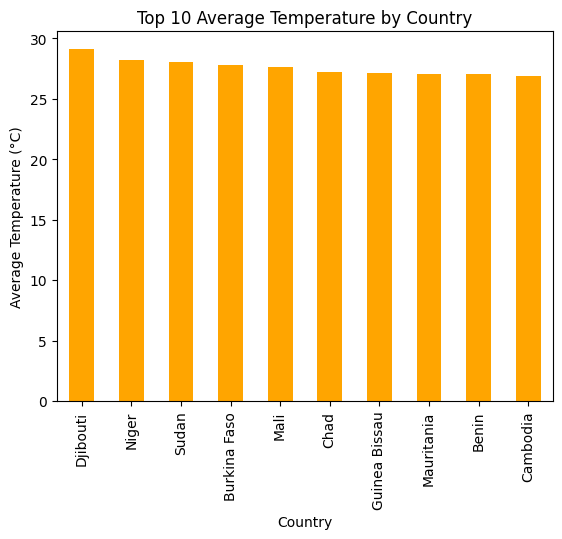

In [26]:
import matplotlib.pyplot as plt


top10 = country_avg.head(10)
top10.plot(kind='bar', color='orange', title='Top 10 Average Temperature by Country')
plt.ylabel('Average Temperature (°C)')
plt.show()

### Temperature Change Over Time - Complete Dataset

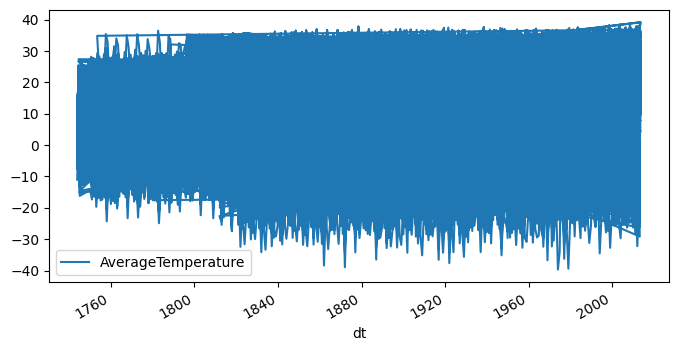

In [27]:
df.plot(x='dt', y='AverageTemperature', figsize=(8,4))
plt.show()


### Global Average Temperature Trend Over Years

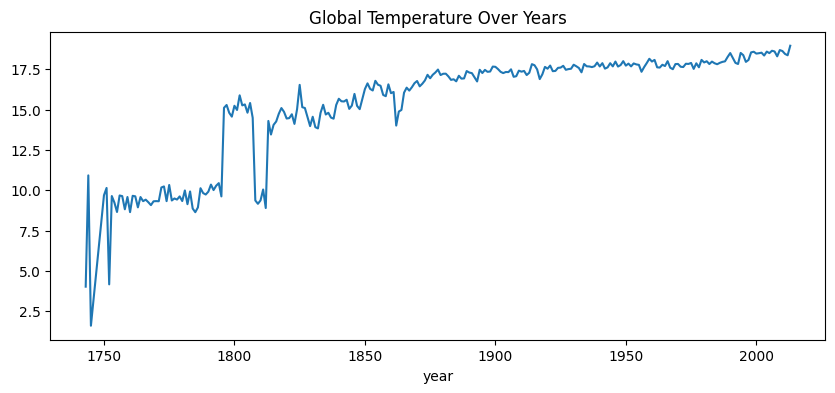

In [28]:
temp_year = df.groupby("year")["AverageTemperature"].mean()
plt.figure(figsize=(10,4))
temp_year.plot()
plt.title("Global Temperature Over Years")
plt.show()

### Countries with Strongest Temperature Increase Trend

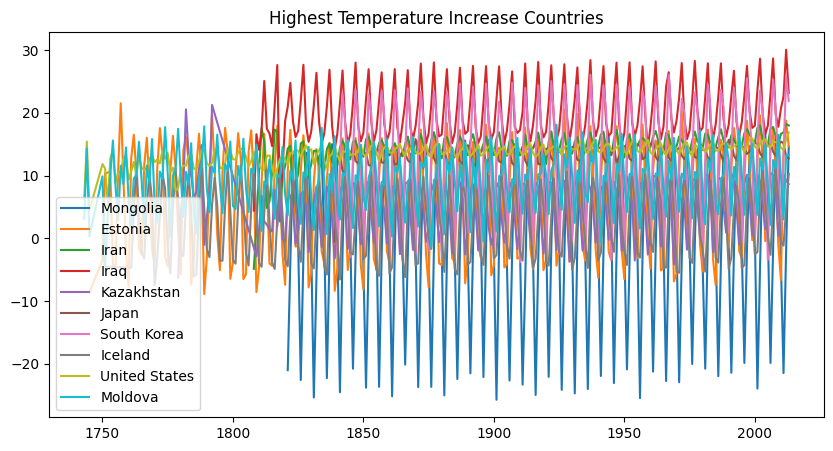

In [29]:
country_year = df.groupby(["Country","year"])["AverageTemperature"].mean().reset_index()
top_countries = (country_year.groupby("Country")["AverageTemperature"]
                 .apply(lambda x: x.iloc[-1]-x.iloc[0]).sort_values(ascending=False).head(10).index)
plt.figure(figsize=(10,5))
for c in top_countries:
    subset = country_year[country_year["Country"]==c]
    plt.plot(subset["year"], subset["AverageTemperature"], label=c)
plt.legend()
plt.title("Highest Temperature Increase Countries")
plt.show()

### Global Monthly Temperature Seasonality Patterns

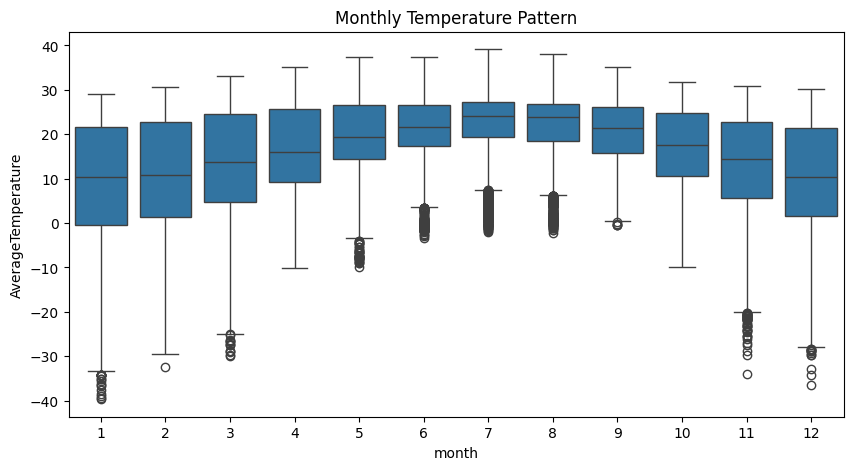

In [30]:
plt.figure(figsize=(10,5))
sns.boxplot(x="month", y="AverageTemperature", data=df)
plt.title("Monthly Temperature Pattern")
plt.show()

### Top 20 Hottest Cities - Average Temperature Ranking

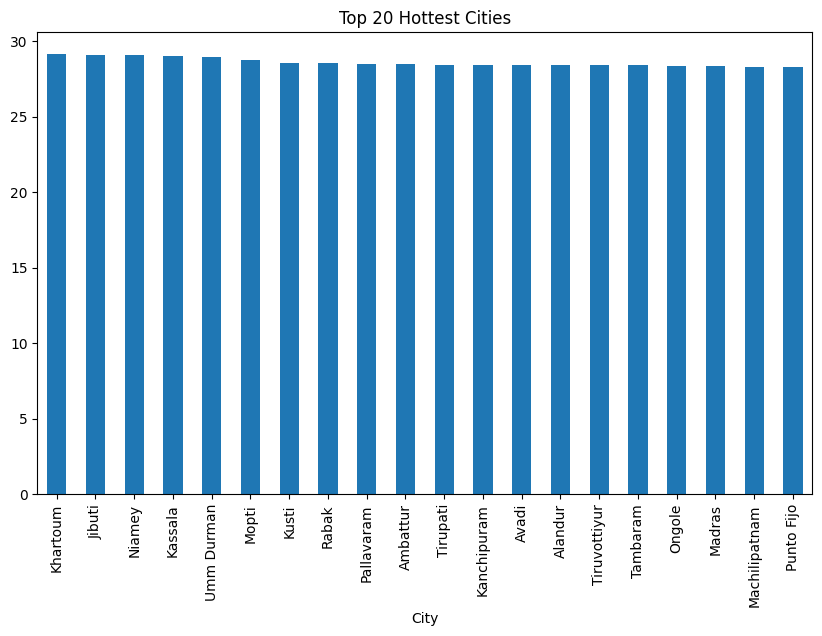

In [31]:
city_mean = df.groupby("City")["AverageTemperature"].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(10,6))
city_mean.plot(kind="bar")
plt.title("Top 20 Hottest Cities")
plt.show()

### Top 20 Coldest Cities - Average Temperature Ranking

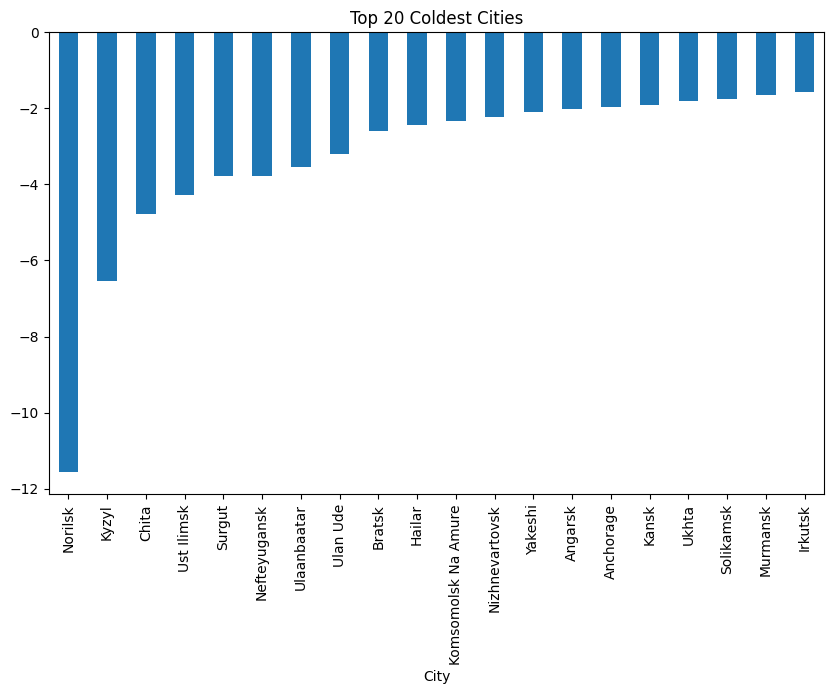

In [32]:
city_cold = df.groupby("City")["AverageTemperature"].mean().sort_values().head(20)
plt.figure(figsize=(10,6))
city_cold.plot(kind="bar")
plt.title("Top 20 Coldest Cities")
plt.show()

### Temperature Measurement Uncertainty Over Time

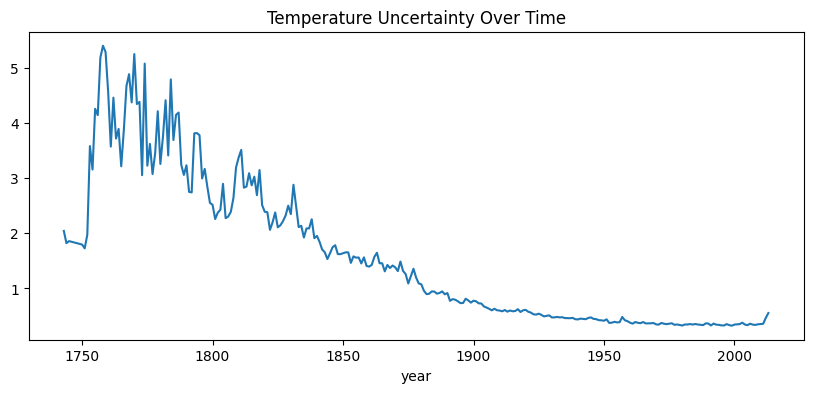

In [33]:
unc_year = df.groupby("year")["AverageTemperatureUncertainty"].mean()
plt.figure(figsize=(10,4))
unc_year.plot()
plt.title("Temperature Uncertainty Over Time")
plt.show()

### Pakistan - Regional Temperature Trends

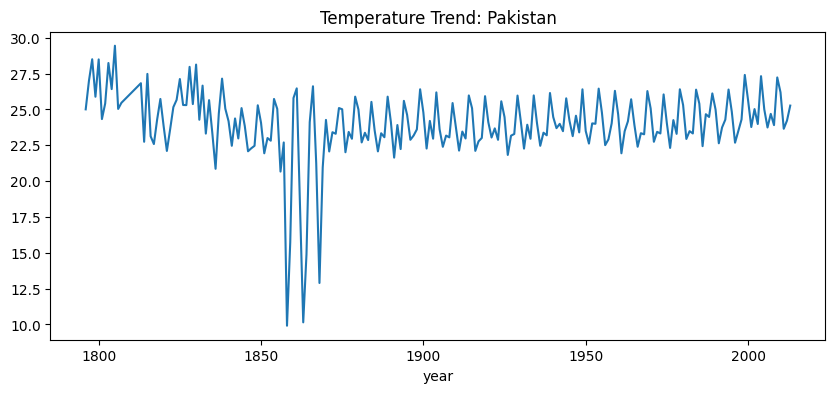

In [34]:
pk = df[df["Country"]=="Pakistan"]
pk_year = pk.groupby("year")["AverageTemperature"].mean()
plt.figure(figsize=(10,4))
pk_year.plot()
plt.title("Temperature Trend: Pakistan")
plt.show()

### Latitude vs Temperature Correlation

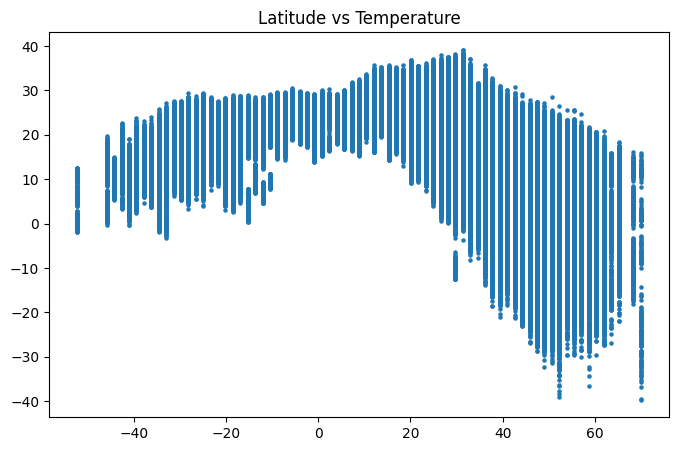

In [35]:
plt.figure(figsize=(8,5))
plt.scatter(df["Latitude"], df["AverageTemperature"], s=5)
plt.title("Latitude vs Temperature")
plt.show()

### Hemisphere Warming Rate Comparison

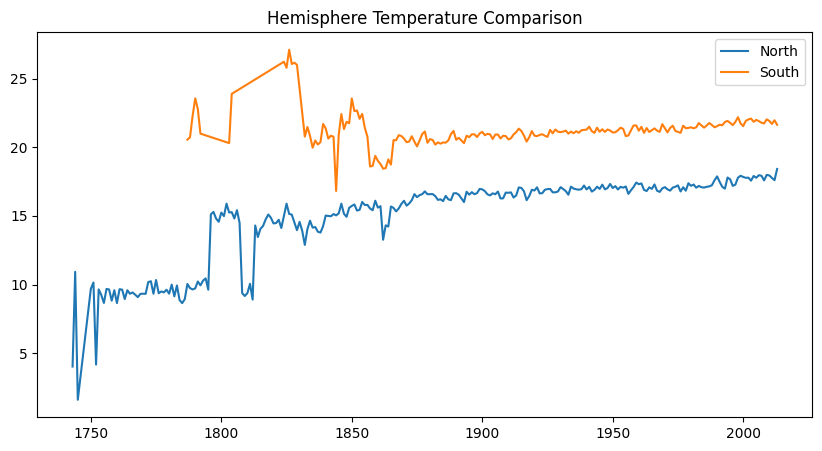

In [36]:
df["hemisphere"] = df["Latitude"].apply(lambda x: "North" if x>=0 else "South")
hem_year = df.groupby(["hemisphere","year"])["AverageTemperature"].mean().reset_index()
plt.figure(figsize=(10,5))
for h in ["North","South"]:
    d = hem_year[hem_year["hemisphere"]==h]
    plt.plot(d["year"], d["AverageTemperature"], label=h)
plt.legend()
plt.title("Hemisphere Temperature Comparison")
plt.show()

### Countries with Highest Temperature Variability

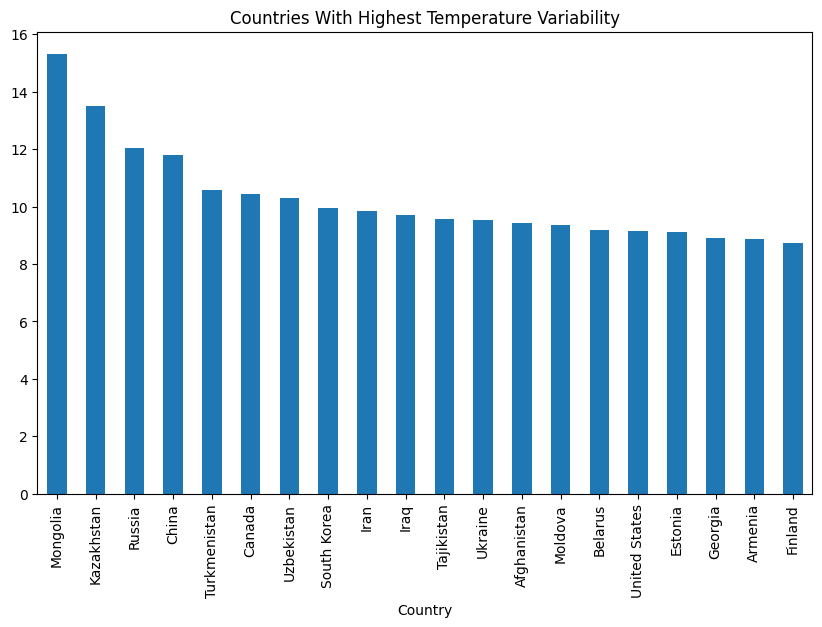

In [37]:
country_std = df.groupby("Country")["AverageTemperature"].std().sort_values(ascending=False).head(20)
plt.figure(figsize=(10,6))
country_std.plot(kind="bar")
plt.title("Countries With Highest Temperature Variability")
plt.show()


### Global Temperature Map - Geographic Distribution

In [38]:
plt.figure(figsize=(8,5))
plt.scatter(df["Longitude"], df["Latitude"], c=df["AverageTemperature"], cmap="coolwarm", s=5)
plt.colorbar(label="Temperature")
plt.title("Geographical Temperature Distribution")
plt.show()

KeyboardInterrupt: 

### City Temperatures within a Country - India Example

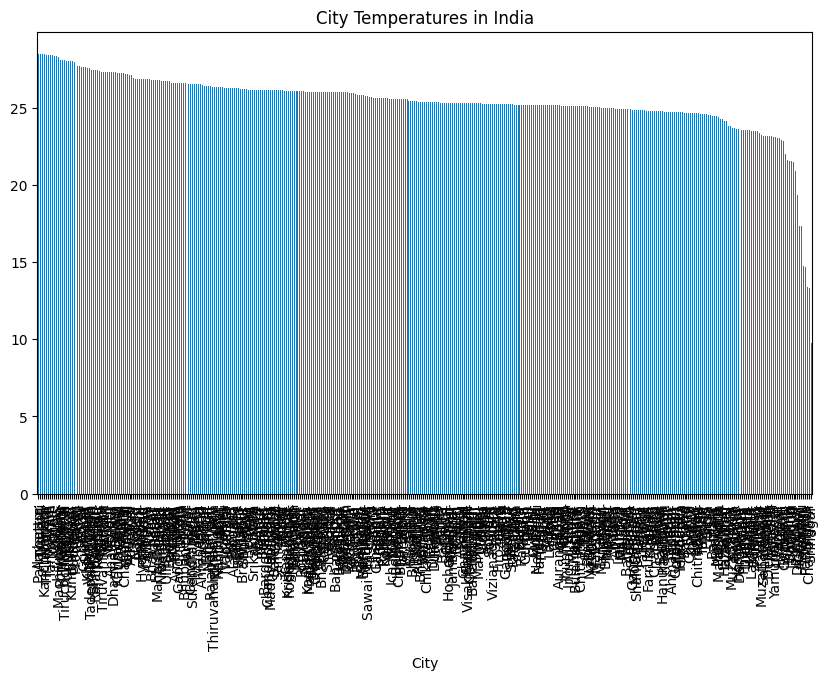

In [ ]:
india = df[df["Country"]=="India"]
india_city = india.groupby("City")["AverageTemperature"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
india_city.plot(kind="bar")
plt.title("City Temperatures in India")
plt.show()

### Monthly Temperature Seasonality - Lahore Example

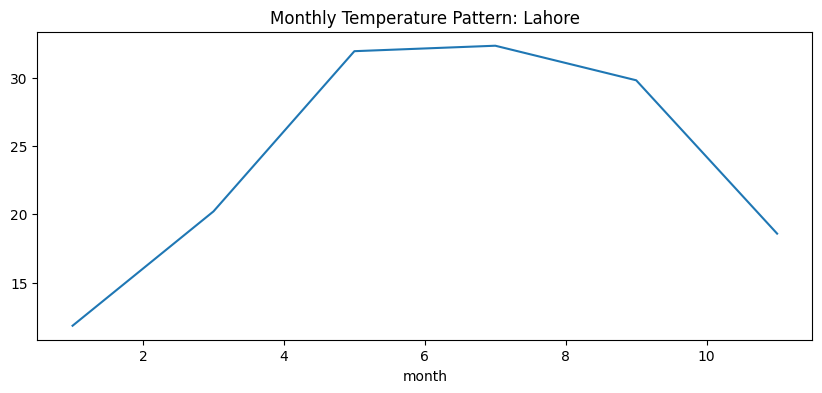

In [ ]:
lahore = df[df["City"]=="Lahore"]
lh_month = lahore.groupby("month")["AverageTemperature"].mean()
plt.figure(figsize=(10,4))
lh_month.plot()
plt.title("Monthly Temperature Pattern: Lahore")
plt.show()

### Warmest Decades in Historical Record

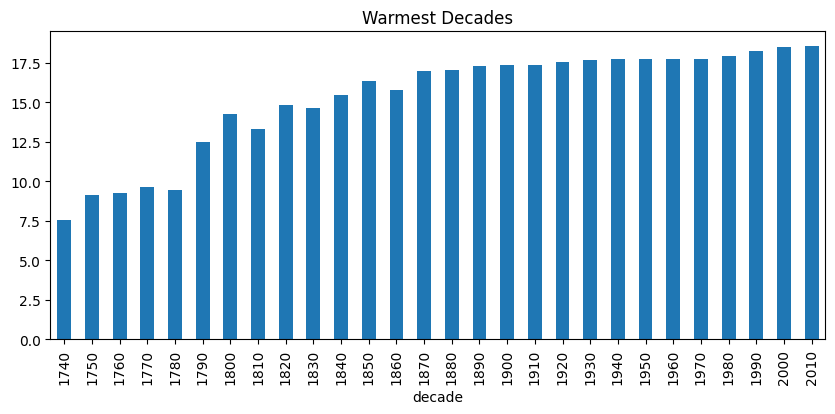

In [ ]:
df["decade"] = (df["year"]//10)*10
dec_mean = df.groupby("decade")["AverageTemperature"].mean()
plt.figure(figsize=(10,4))
dec_mean.plot(kind="bar")
plt.title("Warmest Decades")
plt.show()

### Temperature vs Measurement Uncertainty Relationship

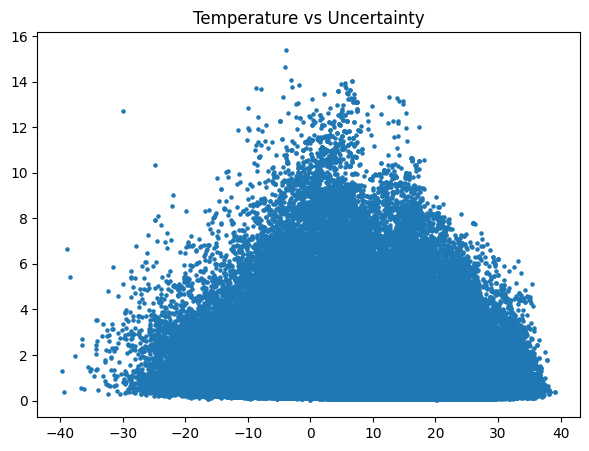

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(df["AverageTemperature"], df["AverageTemperatureUncertainty"], s=5)
plt.title("Temperature vs Uncertainty")
plt.show()

## CLUSTERING & ADVANCED ANALYSIS

### Climate Zone Classification using K-Means

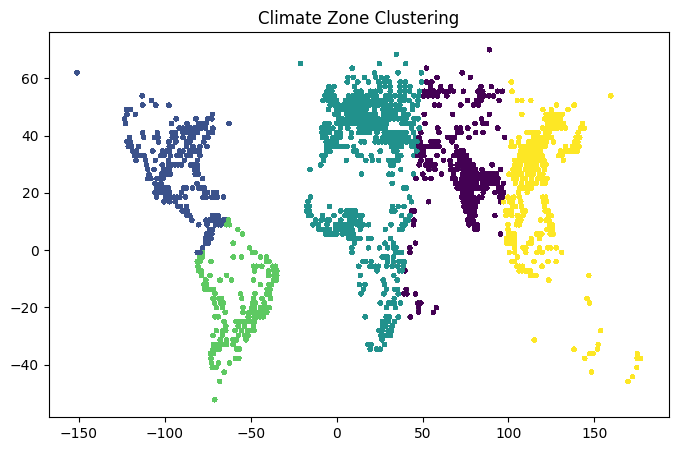

In [ ]:
from sklearn.cluster import KMeans
coords = df[["Latitude","Longitude"]].dropna()
kmeans = KMeans(n_clusters=5, random_state=0).fit(coords)
plt.figure(figsize=(8,5))
plt.scatter(coords["Longitude"], coords["Latitude"], c=kmeans.labels_, s=5)
plt.title("Climate Zone Clustering")
plt.show()

### Historical Temperature Comparison - Pre 1950 vs Post 1950

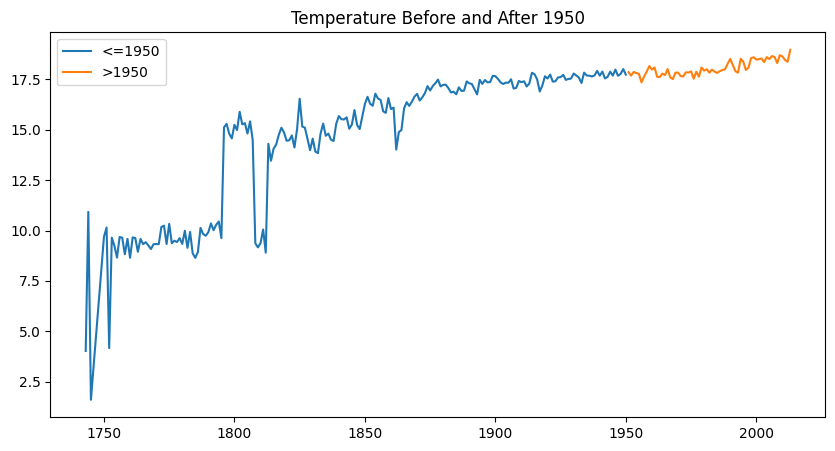

In [ ]:
before = df[df["year"]<=1950].groupby("year")["AverageTemperature"].mean()
after = df[df["year"]>1950].groupby("year")["AverageTemperature"].mean()
plt.figure(figsize=(10,5))
plt.plot(before.index, before.values, label="<=1950")
plt.plot(after.index, after.values, label=">1950")
plt.legend()
plt.title("Temperature Before and After 1950")
plt.show()

### Seasonal Temperature Range by Country

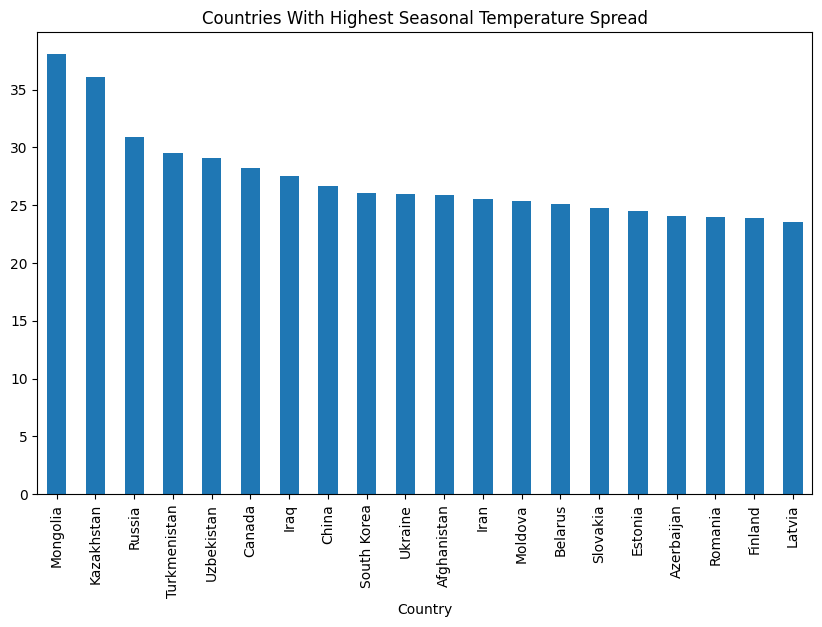

In [ ]:
monthly = df.groupby(["Country","month"])["AverageTemperature"].mean().reset_index()
spread = monthly.groupby("Country")["AverageTemperature"].agg(lambda x: x.max()-x.min())
spread = spread.sort_values(ascending=False).head(20)
plt.figure(figsize=(10,6))
spread.plot(kind="bar")
plt.title("Countries With Highest Seasonal Temperature Spread")
plt.show()

### Yearly Temperature Anomaly from Historical Baseline

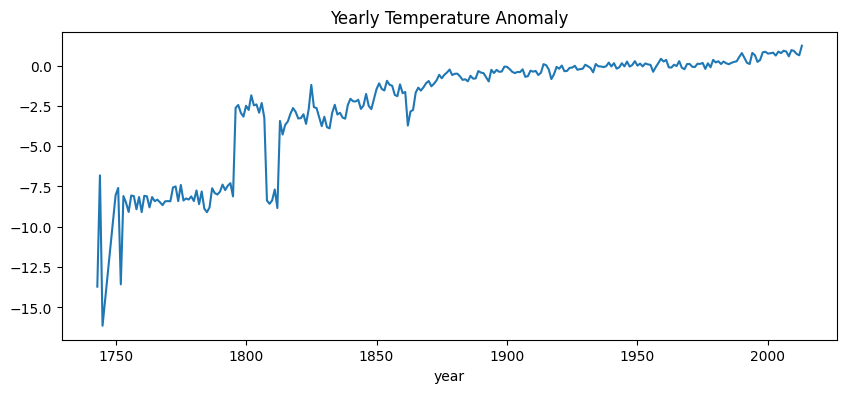

In [ ]:
baseline = df[df["year"].between(1900,2000)].groupby("year")["AverageTemperature"].mean().mean()
anomaly = df.groupby("year")["AverageTemperature"].mean() - baseline
plt.figure(figsize=(10,4))
anomaly.plot()
plt.title("Yearly Temperature Anomaly")
plt.show()